# Text generation model

This model was built following the tutorial: [Building a text generation model from scratch](https://wingedsheep.com/building-a-language-model/).

## Data preparation

First, data is read from a dataset, preprocessing the data is also done.

In [225]:
import csv

with open('datasets/in_domain_dev.tsv') as file:
    tsv_file = csv.reader(file, delimiter='\t')

    data = []

    for line in tsv_file:
        #Reading the data
        data.append(line[-1])

data[0:10]

['The sailors rode the breeze clear of the rocks.',
 'The weights made the rope stretch over the pulley.',
 'The mechanical doll wriggled itself loose.',
 'If you had eaten more, you would want less.',
 'As you eat the most, you want the least.',
 'The more you would want, the less you would eat.',
 'I demand that the more John eat, the more he pays.',
 'Mary listens to the Grateful Dead, she gets depressed.',
 'The angrier Mary got, the more she looked at pictures.',
 'The higher the stakes, the lower his expectations are.']

Special character removal is done for better processing.

In [226]:
import re
from nltk.tokenize import word_tokenize

#List all word tokens removing special characters (didn't --> didnt)
word_tokens = word_tokenize(" ".join([re.sub(r'[^a-zA-Z0-9 \n\.]', '', line) for line in data]))

#New token list without stopwords and punctuation symbols
filtered_tokens = [word.lower() for word in word_tokens if word not in ['.', ',', '?', '!']]

filtered_tokens[0:10]

['the',
 'sailors',
 'rode',
 'the',
 'breeze',
 'clear',
 'of',
 'the',
 'rocks',
 'the']

Text tokenization:

In [227]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(filtered_tokens)

tokenizer.get_config()['word_index']

'{"the": 1, "to": 2, "a": 3, "that": 4, "i": 5, "is": 6, "john": 7, "and": 8, "of": 9, "in": 10, "you": 11, "it": 12, "was": 13, "mary": 14, "he": 15, "did": 16, "which": 17, "will": 18, "be": 19, "book": 20, "bill": 21, "we": 22, "who": 23, "on": 24, "with": 25, "for": 26, "this": 27, "more": 28, "at": 29, "my": 30, "they": 31, "her": 32, "about": 33, "some": 34, "as": 35, "there": 36, "himself": 37, "any": 38, "had": 39, "would": 40, "eat": 41, "his": 42, "not": 43, "have": 44, "man": 45, "him": 46, "can": 47, "by": 48, "read": 49, "she": 50, "has": 51, "up": 52, "me": 53, "put": 54, "want": 55, "leave": 56, "from": 57, "what": 58, "gave": 59, "saw": 60, "anson": 61, "if": 62, "said": 63, "like": 64, "but": 65, "one": 66, "were": 67, "kim": 68, "got": 69, "should": 70, "could": 71, "been": 72, "place": 73, "didnt": 74, "know": 75, "do": 76, "before": 77, "no": 78, "picture": 79, "made": 80, "fred": 81, "get": 82, "likes": 83, "never": 84, "box": 85, "ball": 86, "out": 87, "talked": 8

Finally, a numeric representation for all the text is built:

In [228]:
def text_to_token_list(word_dic: dict, text: list) -> list:
    '''
    Function that turns a text list into a token list, example:
    ["Hello",  "world", "I",  "am",  "a",  "sentence"] --> [0, 1, 3, 4, 2, 5]

    Parameters:
    word_dic: A dictionary that relates every word within the text with a numeric value, i.e. {"Hello": 0, "world": 1, "a": 2, "I": 3, "am": 4, "sentence": 5}.
    text: A list containing the text to tokenize.

    Outputs:
    token_list: A list that contains every word in the text converted into its corresponding numeric representation.
    '''
    if type(text) == list:
        return [word_dic[word] for word in text]
    else:
        return [word_dic[word] for word in text.split()]

In [229]:
#Converting the word list into a token_list
token_list = text_to_token_list(eval(tokenizer.get_config()['word_index']), filtered_tokens)

token_list[0:10]

[1, 461, 462, 1, 463, 464, 9, 1, 465, 1]

## Building the model.

### Layers of the model.

Making and embedding layer:

In [230]:
import torch

class TokenEmbedding(torch.nn.Module):
    """
    PyTorch module that converts tokens into embeddings.

    Input dimension is: (batch_size, sequence_length)
    Output dimension is: (batch_size, sequence_length, d_model)
    """

    def __init__(self, d_model, number_of_tokens):
        '''
        number_of_tokens: total number of unique tokens the model can find in the input.
        d_model: dimensionality of the embedding vectors. 
        '''
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(
            num_embeddings=number_of_tokens,
            embedding_dim=d_model
        )

    def forward(self, x):
        return self.embedding_layer(x)

Making the positional encoding layer:

In [231]:
import numpy as np

class PositionalEncoding(torch.nn.Module):
    """
    Pytorch module that creates a positional encoding matrix. This matrix will later be added to the 
    transformer's input embeddings to provide a sense of position of the sequence elements.
    """

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.d_model = d_model
        self.max_sequence_length = max_sequence_length
        self.positional_encoding = self.create_positional_encoding()

    def create_positional_encoding(self):
        """
        Creates a positional encoding matrix of size (max_sequence_length, d_model).
        """

        # Initialize positional encoding matrix
        positional_encoding = np.zeros((self.max_sequence_length, self.d_model))

        # Calculate positional encoding for each position and each dimension
        for pos in range(self.max_sequence_length):
            for i in range(0, self.d_model, 2):
                # Apply sin to even indices in the array; indices in Python start at 0 so i is even.
                positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.d_model)))
                
                if i + 1 < self.d_model:
                    # Apply cos to odd indices in the array; we add 1 to i because indices in Python start at 0.
                    positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i) / self.d_model)))

        # Convert numpy array to PyTorch tensor and return it
        return torch.from_numpy(positional_encoding).float()

    def forward(self, x):
        """
        Adds the positional encoding to the input embeddings at the corresponding positions.
        """
        # Add positional encodings to input embeddings. The ":" indexing ensures we only add positional encodings up
        # to the length of the sequence in the batch. x.size(0) is the batch size, so this is a way to make sure 
        # we're not adding extra positional encodings.
        return x + self.positional_encoding[:x.size(1), :]

Coding a self attention layer:

In [232]:
class MaskedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a self attention layer.
    This layer is used in the MultiHeadedSelfAttention module.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, head_dimension)
    """

    def __init__(self, embedding_dimension, head_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension
        self.query_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.key_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.value_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, mask):
        """
        Compute the self attention.

        x dimension is: (batch_size, sequence_length, embedding_dimension)
        output dimension is: (batch_size, sequence_length, head_dimension)
        mask dimension is: (batch_size, sequence_length)

        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # x dimensions are: (batch_size, sequence_length, embedding_dimension)
        # query, key, value dimensions are: (batch_size, sequence_length, head_dimension)
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Calculate the attention weights.
        # attention_weights dimensions are: (batch_size, sequence_length, sequence_length)
        attention_weights = torch.matmul(query, key.transpose(-2, -1))

        # Scale the attention weights.
        attention_weights = attention_weights / np.sqrt(self.head_dimension)

        # Apply the mask to the attention weights, by setting the masked tokens to a very low value.
        # This will make the softmax output 0 for these values.
        mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # Softmax makes sure all scores are between 0 and 1 and the sum of scores is 1.
        # attention_scores dimensions are: (batch_size, sequence_length, sequence_length)
        attention_scores = self.softmax(attention_weights)

        # The attention scores are multiplied by the value
        # Values of tokens with high attention score get highlighted because they are multiplied by a larger number,
        # and tokens with low attention score get drowned out because they are multiplied by a smaller number.
        # Output dimensions are: (batch_size, sequence_length, head_dimension)
        return torch.bmm(attention_scores, value)

A multi headed self attention layer:

In [233]:
class MaskedMultiHeadedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a multi head attention layer.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(self, embedding_dimension, number_of_heads):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = embedding_dimension // number_of_heads
        self.number_of_heads = number_of_heads

        # Create the self attention modules
        self.self_attentions = torch.nn.ModuleList(
            [MaskedSelfAttention(embedding_dimension, self.head_dimension) for _ in range(number_of_heads)])

        # Create a linear layer to combine the outputs of the self attention modules
        self.output_layer = torch.nn.Linear(number_of_heads * self.head_dimension, embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the multi head attention.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """
        # Compute the self attention for each head
        # self_attention_outputs dimensions are:
        # (number_of_heads, batch_size, sequence_length, head_dimension)
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attentions]

        # Concatenate the self attention outputs
        # self_attention_outputs_concatenated dimensions are:
        # (batch_size, sequence_length, number_of_heads * head_dimension)
        concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)

        # Apply the output layer to the concatenated self attention outputs
        # output dimensions are: (batch_size, sequence_length, embedding_dimension)
        return self.output_layer(concatenated_self_attention_outputs)

A feed forward neural network layer for the decoder:

In [234]:
class FeedForward(torch.nn.Module):
    """
    Pytorch module for a feed forward layer.

    A feed forward layer is a fully connected layer with a ReLU activation function in between.
    """

    def __init__(self, embedding_dimension, feed_forward_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.feed_forward_dimension = feed_forward_dimension
        self.linear_1 = torch.nn.Linear(embedding_dimension, feed_forward_dimension)
        self.linear_2 = torch.nn.Linear(feed_forward_dimension, embedding_dimension)

    def forward(self, x):
        """
        Compute the feed forward layer.
        """
        return self.linear_2(torch.relu(self.linear_1(x)))

Decoder layers and decoder layer stacks are coded:

In [235]:
class DecoderLayer(torch.nn.Module):
    """
    Pytorch module for a decoder layer.

    A decoder layer consists of a multi-headed self attention layer, a feed forward layer and dropout.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate

        self.multi_headed_self_attention = MaskedMultiHeadedSelfAttention(embedding_dimension, number_of_heads)
        self.feed_forward = FeedForward(embedding_dimension, feed_forward_dimension)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.layer_normalization_1 = torch.nn.LayerNorm(embedding_dimension)
        self.layer_normalization_2 = torch.nn.LayerNorm(embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the decoder layer.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # Layer normalization 1
        normalized_x = self.layer_normalization_1(x)

        # Multi headed self attention
        attention_output = self.multi_headed_self_attention(normalized_x, mask)

        # Residual output
        residual_output = x + attention_output

        # Layer normalization 2
        normalized_residual_output = self.layer_normalization_2(residual_output)

        # Feed forward
        feed_forward_output = self.feed_forward(normalized_residual_output)

        # Dropout, only when training.
        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)

        # Residual output
        return residual_output + feed_forward_output

In [236]:
class DecoderStack(torch.nn.Module):
    """
    Pytorch module for a stack of decoders.
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_layers,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate,
            max_sequence_length
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate
        self.max_sequence_length = max_sequence_length

        # Create the encoder layers
        self.decoder_layers = torch.nn.ModuleList(
            [DecoderLayer(embedding_dimension, number_of_heads, feed_forward_dimension, dropout_rate) for _ in
             range(number_of_layers)])

    def forward(self, x, mask):
        decoder_outputs = x
        for decoder_layer in self.decoder_layers:
            decoder_outputs = decoder_layer(decoder_outputs, mask)

        return decoder_outputs

The language model head:

In [237]:
class LMHead(torch.nn.Module):
    """
    Pytorch module for the language model head.
    The language model head is a linear layer that maps the embedding dimension to the vocabulary size.
    """

    def __init__(self, embedding_dimension, number_of_tokens):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_tokens = number_of_tokens
        self.linear = torch.nn.Linear(embedding_dimension, number_of_tokens)

    def forward(self, x):
        """
        Compute the language model head.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        output dimensions are: (batch_size, sequence_length, number_of_tokens)
        """
        # Compute the linear layer
        # linear_output dimensions are: (batch_size, sequence_length, number_of_tokens)
        linear_output = self.linear(x)

        return linear_output

### The model.

A class that defines the language model:

In [273]:
import os

class LanguageModel(torch.nn.Module):
    """
    Pytorch module for a language model.
    """

    def __init__(
            self,
            number_of_tokens,  # The number of tokens in the vocabulary
            max_sequence_length=512,  # The maximum sequence length to use for attention
            embedding_dimension=512,  # The dimension of the token embeddings
            number_of_layers=6,  # The number of decoder layers to use
            number_of_heads=4,  # The number of attention heads to use
            feed_forward_dimension=None,  # The dimension of the feed forward layer
            dropout_rate=0.1  # The dropout rate to use
    ):
        super().__init__()
        self.number_of_tokens = number_of_tokens
        self.max_sequence_length = max_sequence_length
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads

        if feed_forward_dimension is None:
            # GPT-2 paper uses 4 * embedding_dimension for the feed forward dimension
            self.feed_forward_dimension = embedding_dimension * 4
        else:
            self.feed_forward_dimension = feed_forward_dimension

        self.dropout_rate = dropout_rate

        # Create the token embedding layer
        self.token_embedding = TokenEmbedding(embedding_dimension, number_of_tokens)

        # Create the positional encoding layer
        self.positional_encoding = PositionalEncoding(embedding_dimension, max_sequence_length)

        # Create the normalization layer
        self.layer_normalization = torch.nn.LayerNorm(embedding_dimension)

        # Create the decoder stack
        self.decoder = DecoderStack(
            embedding_dimension=embedding_dimension,
            number_of_layers=number_of_layers,
            number_of_heads=number_of_heads,
            feed_forward_dimension=self.feed_forward_dimension,
            dropout_rate=dropout_rate,
            max_sequence_length=max_sequence_length
        )

        # Create the language model head
        self.lm_head = LMHead(embedding_dimension, number_of_tokens)

    def forward(self, x, mask):
        # Compute the token embeddings
        # token_embeddings dimensions are: (batch_size, sequence_length, embedding_dimension)
        token_embeddings = self.token_embedding(x)

        # Compute the positional encoding
        # positional_encoding dimensions are: (batch_size, sequence_length, embedding_dimension)
        positional_encoding = self.positional_encoding(token_embeddings)

        # Post embedding layer normalization
        positional_encoding_normalized = self.layer_normalization(positional_encoding)

        decoder_outputs = self.decoder(positional_encoding_normalized, mask)
        lm_head_outputs = self.lm_head(decoder_outputs)

        return lm_head_outputs
    
    def save_checkpoint(self, path, model_name, current_loss):
        print(f'Saving checkpoint {path}')

        if not os.path.exists('models/' + model_name):
            os.mkdir('models/' + model_name)

        torch.save({
            'number_of_tokens': self.number_of_tokens,
            'max_sequence_length': self.max_sequence_length,
            'embedding_dimension': self.embedding_dimension,
            'number_of_layers': self.number_of_layers,
            'number_of_heads': self.number_of_heads,
            'feed_forward_dimension': self.feed_forward_dimension,
            'dropout_rate': self.dropout_rate,
            'model_state_dict': self.state_dict()
        }, path)

        with open('models/' + model_name + '/' + model_name + '_loss.txt', 'w') as file:
            file.write(str(current_loss))


    @staticmethod
    def load_checkpoint(path) -> 'LanguageModel':
        checkpoint = torch.load(path)
        model = LanguageModel(
            number_of_tokens=checkpoint['number_of_tokens'],
            max_sequence_length=checkpoint['max_sequence_length'],
            embedding_dimension=checkpoint['embedding_dimension'],
            number_of_layers=checkpoint['number_of_layers'],
            number_of_heads=checkpoint['number_of_heads'],
            feed_forward_dimension=checkpoint['feed_forward_dimension'],
            dropout_rate=checkpoint['dropout_rate']
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        return model

Coding an autoregressive wrapper:

In [274]:
class AutoregressiveWrapper(torch.nn.Module):
    """
    Pytorch module that wraps a GPT model and makes it autoregressive.
    """

    def __init__(self, gpt_model):
        super().__init__()
        self.model = gpt_model
        self.max_sequence_length = self.model.max_sequence_length

    def forward(self, x, mask):
        """
        Autoregressive forward pass
        """
        inp, target = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]

        output = self.model(inp, mask)
        return output, target

    def next_token_probabilities(self, x, mask, temperature=1.0):
        """
        Calculate the token probabilities for the next token in the sequence.
        """
        logits = self.model(x, mask)[:, -1]

        # Apply the temperature
        if temperature != 1.0:
            logits = logits / temperature

        # Apply the softmax
        probabilities = torch.softmax(logits, dim=-1)

        return probabilities
    
    def save_checkpoint(self, path, model_name, current_loss):
        self.model.save_checkpoint(path, model_name, current_loss)

    @staticmethod
    def load_checkpoint(path) -> 'AutoregressiveWrapper':
        model = LanguageModel.load_checkpoint(path)
        return AutoregressiveWrapper(model)

## Training the model.

The training pipeline is coded as follows:

In [275]:
import random

class Trainer:

    def __init__(self, model, optimizer=None):
        super().__init__()
        self.model = model
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        else:
            self.optimizer = optimizer
        self.loss_function = torch.nn.CrossEntropyLoss()

    def train(self, data: list[str], epochs, batch_size, model_name):
        loss_per_epoch = []
        for epoch in range(epochs):
            losses = []

            # Shuffle the sequences
            random.shuffle(data)

            # Create batches of sequences and their respective mask.
            batches = []
            for i in range(0, len(data), batch_size):
                sequence_tensor = torch.tensor(data[i: i + batch_size], dtype=torch.long)

                # Create the mask tensor for the batch, where 1 means the token is not a padding token
                mask_tensor = torch.ones_like(sequence_tensor)
                mask_tensor[sequence_tensor == 0] = 0

                batches.append((sequence_tensor, mask_tensor))

            # Train the model on each batch
            for batch in batches:
                self.model.train()

                # Create the input and mask tensors
                input_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)
                mask_tensor = torch.zeros((batch_size, self.model.max_sequence_length + 1), dtype=torch.long)

                for i, input_entry in enumerate(batch[0]):
                    input_tensor[i] = input_entry

                for i, mask_entry in enumerate(batch[1]):
                    mask_tensor[i] = mask_entry

                # Compute the model output
                model_output, target = self.model.forward(x=input_tensor, mask=mask_tensor)

                # Compute the losses
                # The loss is computed on the model output and the target
                loss = self.loss_function(model_output.transpose(1, 2), target)

                # Backpropagate the loss.
                loss.backward()

                # Clip the gradients. This is used to prevent exploding gradients.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)

                # Update the model parameters. This is done by taking a step in the direction of the gradient.
                self.optimizer.step()

                # Reset the gradients. This is done so that the gradients from the previous batch
                # are not used in the next step.
                self.optimizer.zero_grad()

                # Append the loss to the list of losses, so that the average loss can be computed for this epoch.
                losses.append(loss.item())

            # Print the loss
            epoch_loss = np.average(losses)
            loss_per_epoch.append(epoch_loss)
            print('Epoch:', epoch + 1, 'Loss:', epoch_loss)

            if (epoch + 1) % 5 == 0:
                self.model.save_checkpoint('models/' + model_name + '/' + model_name, model_name, epoch_loss)

        return loss_per_epoch

Epoch: 1 Loss: 4.410200036266475
Epoch: 2 Loss: 1.6455686115524144
Epoch: 3 Loss: 0.5773618327037802
Epoch: 4 Loss: 0.2545467774844864
Epoch: 5 Loss: 0.15870444928702798
Saving checkpoint models/model_1/model_1
Epoch: 6 Loss: 0.112640475203256
Epoch: 7 Loss: 0.08426733445556997
Epoch: 8 Loss: 0.0644065858778155
Epoch: 9 Loss: 0.05068288335251143
Epoch: 10 Loss: 0.0429190559375995
Saving checkpoint models/model_1/model_1
Epoch: 11 Loss: 0.036424185693245924
Epoch: 12 Loss: 0.030711722137288924
Epoch: 13 Loss: 0.025146619651864453
Epoch: 14 Loss: 0.02290428656218935
Epoch: 15 Loss: 0.01932277317527338
Saving checkpoint models/model_1/model_1
Epoch: 16 Loss: 0.01725852872150073
Epoch: 17 Loss: 0.016374266796261614
Epoch: 18 Loss: 0.015242967931598931
Epoch: 19 Loss: 0.012955165017188247
Epoch: 20 Loss: 0.012672155498508907
Saving checkpoint models/model_1/model_1
Epoch: 21 Loss: 0.01184241303651892
Epoch: 22 Loss: 0.010927177570168001
Epoch: 23 Loss: 0.009491385779602372
Epoch: 24 Loss: 0

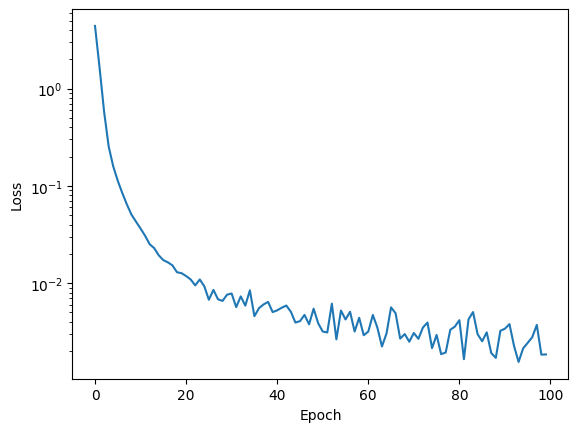

In [276]:
import matplotlib.pyplot as plt

def create_training_sequences(max_sequence_length, tokenized_training_data):
    # Create sequences of length max_sequence_length + 1
    # The last token of each sequence is the target token
    sequences = []
    for i in range(0, len(tokenized_training_data) - max_sequence_length - 1):
        sequences.append(tokenized_training_data[i: i + max_sequence_length + 1])
    return sequences


def pad_training_data(max_sequence_length, tokenized_training_data):
    for _ in range(max_sequence_length):
        # Prepend padding tokens
        tokenized_training_data.insert(0, 0)
    return tokenized_training_data

embedding_dimension = 256
max_sequence_length = 20
number_of_tokens = len(eval(tokenizer.get_config()['word_index']))

# Create the model
model = AutoregressiveWrapper(LanguageModel(
    embedding_dimension=embedding_dimension,
    number_of_tokens=number_of_tokens,
    number_of_heads=4,
    number_of_layers=3,
    dropout_rate=0.1,
    max_sequence_length=max_sequence_length
))


tokenized_and_padded_training_data = pad_training_data(max_sequence_length, token_list)
sequences = create_training_sequences(max_sequence_length, tokenized_and_padded_training_data)

# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = Trainer(model, optimizer)
loss_per_epoch = trainer.train(sequences, epochs=100, batch_size=8, model_name='model_1')

# Plot the loss per epoch in log scale
plt.plot(loss_per_epoch)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Testing and saving the model.

Saving the model.

In [ ]:
model.save_checkpoint('models/model_1/model_1', 'model_1', loss_per_epoch[-1])

A generator class is coded to switch the model to evaluation mode. 

In [ ]:
def pad_left(sequence, final_length, padding_token):
    return [padding_token] * (final_length - len(sequence)) + sequence


class Generator:

    def __init__(
            self,
            model,
            tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.tokenizer_word_index = self.tokenizer.word_index
        self.tokenizer_index_word = self.tokenizer.index_word
        

    def generate(
            self,
            max_tokens_to_generate: int,
            prompt: str = None,
            temperature: float = 1.0,
            eos_token: int = None,
            padding_token: int = 0):

        self.model.eval()

        self.tokenizer_word_index['<pad>'] = padding_token
        self.tokenizer_index_word[padding_token] = '<pad>'

        if prompt is None:
            start_tokens = [0]
        else:
            self.tokenizer.fit_on_texts(prompt)
            start_tokens = text_to_token_list(self.tokenizer_word_index, prompt.lower())
            print(start_tokens)

        input_tensor = torch.tensor(
            pad_left(
                sequence=start_tokens,
                final_length=self.model.max_sequence_length + 1,
                padding_token=padding_token
            ),
            dtype=torch.long
        )

        num_dims = len(input_tensor.shape)

        if num_dims == 1:
            input_tensor = input_tensor[None, :]

        out = input_tensor
        for _ in range(max_tokens_to_generate):

            x = out[:, -self.model.max_sequence_length:]

            mask = torch.ones_like(x)
            mask[x == padding_token] = 0

            # Compute the next token probabilities
            next_token_probabilities = self.model.next_token_probabilities(
                x=x,
                temperature=temperature,
                mask=mask
            )

            # Sample the next token from the probability distribution
            next_token = torch.multinomial(next_token_probabilities, num_samples=1)

            # Append the next token to the output
            out = torch.cat([out, next_token], dim=1)

            # If the end of sequence token is reached, stop generating tokens
            if eos_token is not None and next_token == eos_token:
                break

        generated_tokens = out[0].tolist()
        return ' '.join([self.tokenizer_index_word[token] for token in generated_tokens])

Testing the model.

In [ ]:
max_tokens_to_generate = 50
generator = Generator(model, tokenizer)
generated_text = generator.generate(
    max_tokens_to_generate=max_tokens_to_generate,
    prompt="city and",
    padding_token=0
)
print(generated_text.replace('<pad>', ''))

[1321, 8]


IndexError: index out of range in self

Loading the model:

In [ ]:
model_name = 'MODEL NAME HERE'

language_model = LanguageModel.load_checkpoint(model_name)